# NNで株価を予測モデルを作成する

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import pandas_profiling as pdp
import seaborn as sns
%matplotlib inline

# tsvファイルの読み込み csvではないので、delimiterオプションを設定
#df_train_law = pd.read_csv('/Users/apple/python/stock/StockModelpytorch/data/2017_1321.csv' ,index_col=0)


# NNを組んで見る

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# データセットを作る
## PytorchのLSTMに学習させるためのデータは次元の工夫が必要であり、二重リストのようなかたちになる

In [4]:
window = 6

df_train_law = pd.read_csv('./data/three_year_stock_data.csv' ,index_col=0)
df_train_law.head()
inp_dim = len(df_train_law)

open = df_train_law.open.values
nd_cast = open.astype(np.float32)

X_train, y_train, X_test, y_test= [], [], [], []
tmp = []

for i in nd_cast:
    tmp.append([i])

for i in range(inp_dim - window):
    X_train.append(tmp[i:i+window])
    y_train.append(tmp[i+window])

In [5]:
print( len(X_train[0]) )
print( len(X_train) )

print(X_train[0])
print(X_train[1])
print(X_train[2])
print(y_train[0])
print(y_train[1])

6
698
[[19790.0], [20100.0], [19850.0], [19910.0], [19860.0], [19760.0]]
[[20100.0], [19850.0], [19910.0], [19860.0], [19760.0], [19660.0]]
[[19850.0], [19910.0], [19860.0], [19760.0], [19660.0], [19710.0]]
[19660.0]
[19710.0]


In [6]:
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)

## Dataを組むまでの流れ
1. Datasetクラスを作成する 
    1. 入力データと正解データにわける tensorにすること pd->np->tensorに変換する必要がある
    1. \__len__と\__getitem__を用意すること
1. Dataloaderを準備  
Datasetクラスで作ったやつをinputするだけなので難易度は低い
    

 ### datasetクラスを作成する

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,  X , y , mode='train' ,transform = None):
        self.data = X
        self.label = y
        self.num = len(X)
        self.mode= mode
        self.transform = transform
       
    
    def __len__(self):                         ###データの大きさをreturn するlenメソッドを必ず作成する必要がある
        return self.num
    
    def __getitem__(self, idx):           ###正解データと入力データが対となるようなgetitemメソッドを必ず作成する必要がある
        
        out_data = self.data[idx]
        out_label =  self.label[idx]
        
        return out_data, out_label
        

### XとyをDatasetクラスを継承させて作った自作クラスにinput

In [48]:
trainset = Dataset( X_train , y_train )

In [49]:
dataloader = torch.utils.data.DataLoader(dataset=trainset, batch_size = 4, shuffle=True)   

### 中身の確認

In [50]:
dataiter = iter(dataloader)

X, labal = dataiter.next()

In [51]:
X.shape

torch.Size([4, 6, 1])

In [52]:
print(X[1].shape)
print(X[1])
print(labal[1])

torch.Size([6, 1])
tensor([[22800.],
        [22700.],
        [22580.],
        [22700.],
        [22870.],
        [22950.]])
tensor([23150.])


## モデルの構築

In [61]:
import torch
import torch.nn as nn


class Predictor(nn.Module):
    def __init__(self, inputDim, hiddenDim, outputDim):
        super(Predictor, self).__init__()

        self.lstm = nn.LSTM(input_size = inputDim,
                            hidden_size = hiddenDim,
                            batch_first = True)
        self.output_layer = nn.Linear(hiddenDim, outputDim)
    
    def forward(self, inputs, hidden0=None):
        
        output, (hidden, cell) = self.lstm(inputs, hidden0) #LSTM層
        output = self.output_layer(output[:, -1, :]) #全結合層

        return output


In [62]:
model = Predictor(1,100,1)    # inputの次元は? 株価onlyだから1次元となるのか、それとも時間を5個分とってくるから 5次元？？
model

Predictor(
  (lstm): LSTM(1, 100, batch_first=True)
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
)

In [55]:
# 損失関数
criterion = nn.MSELoss()      ### 損失化関数は二乗誤差を設定。　回帰モデルなのでOK
# 最適化関数
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)     ### lrは学習率

In [56]:
ls_loss = []

for epoch in range(3):
    
    model.train()
    for i, (X, label) in enumerate(dataloader):

        X.long()
        label.long()

        print("=======")
        print(X)
        
        # 勾配の初期化
        optimizer.zero_grad()     
        
        y_pred = model( X )          ### ニューラルネットで計算したoutputを保存
        
        print("y_pred : ",y_pred)
        
        loss = criterion(y_pred, label) ###教師データとoutputから損失関数を計算
        
        # バッチごとのロスを記録する
        ls_loss.append(loss)
        
        # 勾配の計算
        loss.backward()           ### 損失関数を微分 = 勾配の計算
        
        # パラメータの更新
        optimizer.step()           
        
        #print('*** by optimizer.step()')
       # print(model.lstm.weight)
    

tensor([[[20420.],
         [20460.],
         [20280.],
         [20460.],
         [20470.],
         [20520.]],

        [[19840.],
         [20120.],
         [20270.],
         [20270.],
         [20170.],
         [20530.]],

        [[19560.],
         [19240.],
         [19550.],
         [19540.],
         [19450.],
         [19290.]],

        [[24490.],
         [24330.],
         [24410.],
         [24460.],
         [24390.],
         [24430.]]])


NameError: name 'hidden0' is not defined

### ロスの確認

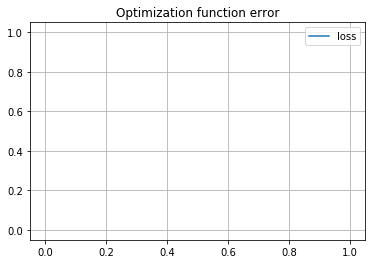

In [21]:
plt.figure()
plt.plot(ls_loss,label="loss")
plt.title('Optimization function error') # 最適化関数の誤差
plt.legend()
plt.grid()

## できあがったmodelでテストを行ってみる

In [112]:
test

NameError: name 'test' is not defined

In [87]:
X_pd_test = test.drop('log_price',  axis=1)
y_pd_test = test['log_price']

In [88]:
X_pd_test = X_pd_test.values
y_pd_test = y_pd_test.values

X_pd_test = torch.from_numpy(X_pd_test.astype(np.float32)).clone()
y_pd_test = torch.from_numpy(y_pd_test.astype(np.float32)).clone()

In [89]:
testset = PdDataset( X_pd_test , y_pd_test )
dataloader = torch.utils.data.DataLoader(dataset=testset, batch_size = 32, shuffle=True)

In [90]:
#model.train()
for i, (inputPd, pricePd) in enumerate(testset):

    print("@@@@@@@@@@@@", i)
    
    print(inputPd)
    
    y = model(inputPd)

    print("y_pred : ",y)
    
    if i==4:
        break

@@@@@@@@@@@@ 0
tensor([0.0000, 0.1539, 0.0000, 0.9425, 0.1905, 0.0315])
y_pred :  tensor([2.9495], grad_fn=<SqueezeBackward3>)
@@@@@@@@@@@@ 1
tensor([1.0000, 0.0402, 0.0000, 0.0637, 0.0000, 0.9484])
y_pred :  tensor([3.1888], grad_fn=<SqueezeBackward3>)
@@@@@@@@@@@@ 2
tensor([0.0000, 0.8875, 0.0000, 1.0000, 0.9368, 0.1176])
y_pred :  tensor([3.5809], grad_fn=<SqueezeBackward3>)
@@@@@@@@@@@@ 3
tensor([1.0000, 0.9762, 0.0000, 0.0622, 0.0000, 0.1023])
y_pred :  tensor([3.0982], grad_fn=<SqueezeBackward3>)
@@@@@@@@@@@@ 4
tensor([1.0000, 0.2645, 0.0000, 0.0249, 0.7989, 0.2553])
y_pred :  tensor([2.7945], grad_fn=<SqueezeBackward3>)
